# **Collaborative Filtering DLRM**

In [240]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model
from keras.utils.vis_utils import plot_model

from scipy.sparse import vstack
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [241]:
filepath = '/content/drive/My Drive/Assignments/256/Assignment-2/Dataset/finalDataSet.csv'
bookDF = pd.read_csv(filepath)
bookDF.drop(bookDF.columns[bookDF.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#bookDF.head()

In [242]:
df = bookDF.drop(['title'],axis=1)
df.rating.unique()

array([3, 4, 2, 0, 5, 1])

# **Mappings**

In [243]:
#create mappings

user_ids = df["user_id"].unique().tolist()
user2idx = {x: i for i, x in enumerate(user_ids)}

book_ids = df["book_id"].unique().tolist()
book2idx = {x: i for i, x in enumerate(book_ids)}
idx2book = {i: x for i, x in enumerate(book_ids)}

genres = df["genre"].unique().tolist()
genres2idx = {x: i for i, x in enumerate(genres)}

author_names = df["author_name"].unique().tolist()
author2idx = {x: i for i, x in enumerate(author_names)}

country_code = df["country_code"].unique().tolist()
cc2idx = {x: i for i, x in enumerate(country_code)}

language_code = df["language_code"].unique().tolist()
lc2idx = {x: i for i, x in enumerate(language_code)}

is_ebook = df["is_ebook"].unique().tolist()
ebook2idx = {x: i for i, x in enumerate(is_ebook)}

df["user"] = df["user_id"].map(user2idx)
df["book"] = df["book_id"].map(book2idx)
df["genre_n"] = df["genre"].map(genres2idx)
df["author"] = df["author_name"].map(author2idx)
df["country"] = df["country_code"].map(cc2idx)
df["language"] = df["language_code"].map(lc2idx)
df["ebook"] = df["is_ebook"].map(ebook2idx)

num_users = len(user2idx)
num_books = len(book2idx)
num_genres = len(genres2idx)
num_authors = len(author2idx)
num_cc = len(cc2idx)
num_lc = len(lc2idx)
num_ebook = len(ebook2idx)

X = df[["user", "book", "genre_n", "author","ebook"]].values

# Normalize the targets between 0 and 1.
y = df["rating"].apply(lambda x: x/ 5).values

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.7,random_state=42)

# **Embedding Layers**

In [244]:
# embedding size for 50
embedding_size = 50

user_id_input = Input(shape=[1],name="user")
book_id_input = Input(shape=[1],name="book")
genre_input = Input(shape=[1],name="genre")
author_input = Input(shape=[1],name="author")
cc_input = Input(shape=[1],name="cc")
lc_input = Input(shape=[1],name="lc")
ebook_input = Input(shape=[1],name="ebook")

# Create embedding layers

user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=num_users,
                           input_length=1, 
                           embeddings_initializer="he_normal",
                           embeddings_regularizer=keras.regularizers.l2(1e-6),
                           name='user_embedding')(user_id_input)

book_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_books,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='book_embedding')(book_id_input)

genre_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=num_genres,
                           input_length=1, 
                           embeddings_initializer="he_normal",
                           embeddings_regularizer=keras.regularizers.l2(1e-6),
                           name='genre_embedding')(genre_input)

author_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_authors,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='author_embedding')(author_input)

cc_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_cc,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='cc_embedding')(cc_input)

lc_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_lc,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='lc_embedding')(lc_input)

ebook_embedding = Embedding(output_dim=embedding_size, 
                            input_dim=num_ebook,
                            input_length=1, 
                            embeddings_initializer="he_normal",
                            embeddings_regularizer=keras.regularizers.l2(1e-6),
                            name='ebook_embedding')(ebook_input)

# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
book_vector = Reshape([embedding_size])(book_embedding)
genre_vector = Reshape([embedding_size])(genre_embedding)
author_vector = Reshape([embedding_size])(author_embedding)
cc_vector = Reshape([embedding_size])(cc_embedding)
lc_vector = Reshape([embedding_size])(lc_embedding)
ebook_vector = Reshape([embedding_size])(ebook_embedding)

concat = Concatenate()([user_vector,book_vector,genre_vector,author_vector,ebook_vector])

# **Creating Model**

In [ ]:
#Creating Model

Dense1 = Dense(256)(concat)
Dense2 = Dropout(0.2)(Dense1)

# Using sigmoid activation to enforce the rating between 0 and 1
y = Dense(1, activation="sigmoid")(Dense2)

model = Model(inputs=[user_id_input,book_id_input,genre_input,author_input,ebook_input],outputs=y)
model.compile(loss='mse',  optimizer = 'adam')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=2)

In [ ]:
history = model.fit(x = [X_train[:,0],X_train[:,1],X_train[:,2],X_train[:,3],X_train[:,4]],
                    y=y_train,
                    batch_size=256,
                    epochs=2,
                    validation_data=([X_val[:,0],X_val[:,1],X_val[:,2],X_val[:,3],X_val[:,4]],y_val),
                    callbacks = [callback]
                    )

Epoch 1/2
3721/3721 [==============================] - 989s 266ms/step - loss: 0.0494 - val_loss: 0.0496
Epoch 2/2
3721/3721 [==============================] - 981s 264ms/step - loss: 0.0446 - val_loss: 0.0496


# **Save the Model**

In [ ]:
model.save('/content/drive/My Drive/Assignments/256/Assignment-2/Model ')

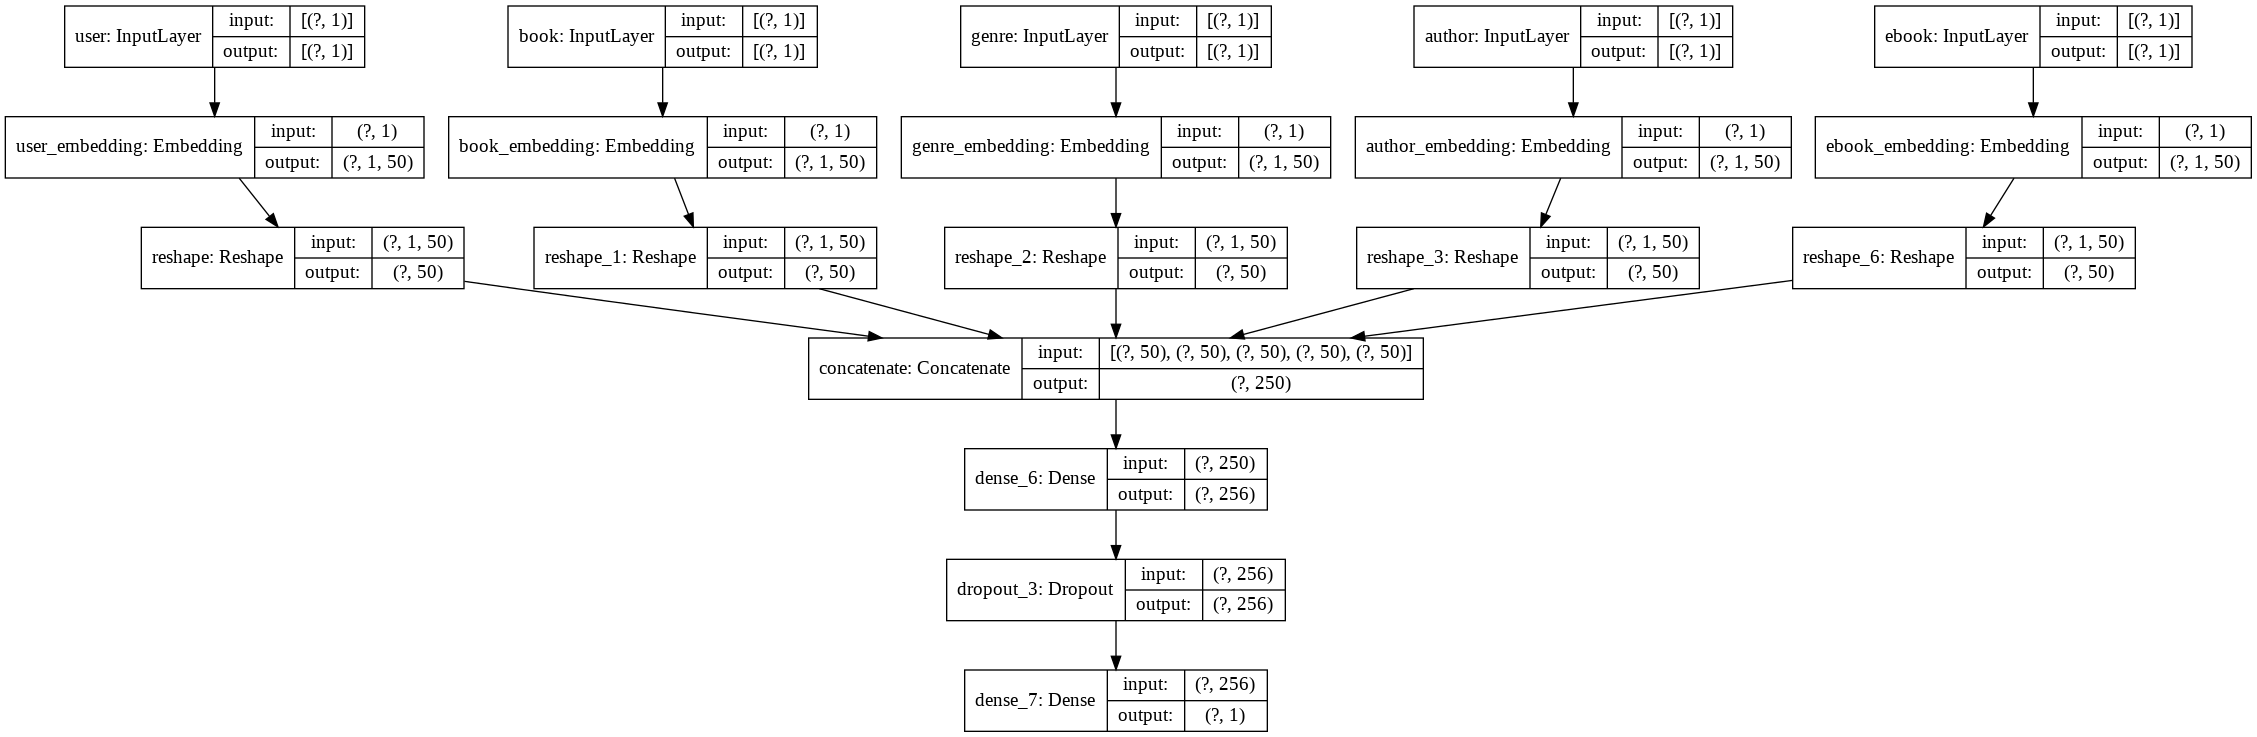

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# **Load Model**

In [245]:
model = keras.models.load_model('/content/drive/My Drive/Assignments/256/Assignment-2/Model ')

In [ ]:
# Comparing Predicted and Actual values for 10 results
p , a = (model.predict([X_val[:10,0], X_val[:10,1], X_val[:10,2], X_val[:10,3], X_val[:10,4]]) , y_val[:10])
print("Ratings Normalized between 0 and 1 which were original between 1 and 5")
for i in range(len(p)):
    print("predicted: "+ str(np.round(p[i],1)) +" actual: "+ str(round(a[i],1)) )

Ratings Normalized between 0 and 1 which were original between 1 and 5
predicted: [0.7] actual: 1.0
predicted: [0.5] actual: 0.6
predicted: [0.8] actual: 0.0
predicted: [0.8] actual: 1.0
predicted: [0.9] actual: 1.0
predicted: [0.6] actual: 0.4
predicted: [0.7] actual: 1.0
predicted: [0.7] actual: 0.8
predicted: [0.9] actual: 1.0
predicted: [0.8] actual: 0.8


# **Recommendation Test Case for Colab Notebook**

In [247]:
def get_recommendations(user_id):
  books_read_by_user = df[df.user_id == user_id]
  user = books_read_by_user.user.unique()
  books_not_read = df[~df["book_id"].isin(books_read_by_user.book_id.values)]["book"]
  books_not_read.drop_duplicates(inplace=True)
  books_not_read = list(
          set(books_not_read).intersection(set(book2idx.keys()))
      )
  books_not_read = np.array(books_not_read)

  user_input = [user[0]] * len(books_not_read)
  user_input = np.array(user_input)
  genre_input = np.random.randint(0,2,len(books_not_read))
  author_input = np.random.randint(0,31502,len(books_not_read))
  ebook_input = np.random.randint(0,2,len(books_not_read))

  ratings = model.predict([books_not_read, user_input,genre_input,author_input,ebook_input]).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  
  recommended_books_ids = [
      idx2book.get(books_not_read[x]) for x in top_ratings_indices
  ]
  recommended_books_ids = set(recommended_books_ids)
  
  print("Showing recommendations for user: {}".format(user_id))
  print("=" * 36)
  print("Books with high ratings from user")
  print("-" * 36)
  top_books_user = (
      books_read_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .book_id.values
  )
  book_df_rows = bookDF[bookDF["book_id"].isin(top_books_user)]
  result1 = set()
  for row in book_df_rows.itertuples():
      result1.add(row.title + " : " + row.genre)

  for res in result1:
    print(res)

  print("-" * 36)
  print(" Top 10 Book recommendations")
  print("-" * 36)

  recommended_books = bookDF[bookDF["book_id"].isin(recommended_books_ids)][['book_id','title','genre']]
  result2 = set()
  for row in recommended_books.itertuples():
      result2.add(row.title + " : " + row.genre)

  for res in result2:
    print(res)

In [ ]:
get_recommendations('18b61748a52de671cb549d812b9740c8')

Showing recommendations for user: 18b61748a52de671cb549d812b9740c8
Books with high ratings from user
------------------------------------
Redwall (Redwall, #1) : Fantasy and Paranormal
The Last Watch (Watch #4) : Fantasy and Paranormal
Dragon Rider (Dragon Rider, #1) : Fantasy and Paranormal
Neverwhere : Fantasy and Paranormal
The Princess Bride : Fantasy and Paranormal
------------------------------------
 Top Book recommendations
------------------------------------
The Witching Hour (Lives of the Mayfair Witches, #1) : Fantasy and Paranormal
Changes (The Dresden Files, #12) : Fantasy and Paranormal
Naruto Vol. 54 : Comics and Graphics
Griffin's Daughter (Griffin's Daughter Trilogy, #1) : Fantasy and Paranormal
Apocalipsis : Fantasy and Paranormal
Naruto Vol. 54 : Fantasy and Paranormal
The Chronicles of Prydain Boxed Set (The Chronicles of Prydain #1-5) : Fantasy and Paranormal
A New Hope  (Star Wars: Novelizations #4) : Fantasy and Paranormal
My Protector (Bewitched and Bewildered,

In [ ]:
get_recommendations('b0ed09d14a462cb2d27327b87edf6f68')

Showing recommendations for user: b0ed09d14a462cb2d27327b87edf6f68
Books with high ratings from user
------------------------------------
The Djinn in the Nightingale's Eye : Fantasy and Paranormal
Wolves and Witches : Fantasy and Paranormal
The Autumnlands, Vol. 1: Tooth and Claw : Comics and Graphics
The Lake : Fantasy and Paranormal
Castles : Fantasy and Paranormal
------------------------------------
 Top Book recommendations
------------------------------------
Mud : Fantasy and Paranormal
Changes (The Dresden Files, #12) : Fantasy and Paranormal
Naruto Vol. 54 : Comics and Graphics
Griffin's Daughter (Griffin's Daughter Trilogy, #1) : Fantasy and Paranormal
Naruto Vol. 54 : Fantasy and Paranormal
Sky Dragons : Fantasy and Paranormal
The Chronicles of Prydain Boxed Set (The Chronicles of Prydain #1-5) : Fantasy and Paranormal
A New Hope  (Star Wars: Novelizations #4) : Fantasy and Paranormal
Ghosts of Memories : Fantasy and Paranormal
A Clash of Kings (A Song of Ice and Fire, #2) 

# **Store Recommendation for 50 users to display on the UI**

In [268]:
def get_recommendationsUI(user_id):
  books_read_by_user = df[df.user_id == user_id]
  user = books_read_by_user.user.unique()
  books_not_read = df[~df["book_id"].isin(books_read_by_user.book_id.values)]["book"]
  books_not_read.drop_duplicates(inplace=True)
  books_not_read = list(
          set(books_not_read).intersection(set(book2idx.keys()))
      )
  books_not_read = np.array(books_not_read)

  user_input = [user[0]] * len(books_not_read)
  user_input = np.array(user_input)
  genre_input = np.random.randint(0,2,len(books_not_read))
  author_input = np.random.randint(0,31502,len(books_not_read))
  ebook_input = np.random.randint(0,2,len(books_not_read))

  ratings = model.predict([books_not_read, user_input,genre_input,author_input,ebook_input]).flatten()
  top_ratings_indices = ratings.argsort()[-10:][::-1]
  
  recommended_books_ids = [
      idx2book.get(books_not_read[x]) for x in top_ratings_indices
  ]
  recommended_books_ids = set(recommended_books_ids)
  
  top_books_user = (
      books_read_by_user.sort_values(by="rating", ascending=False)
      .head(5)
      .book_id.values
  )
  book_df_rows = bookDF[bookDF["book_id"].isin(top_books_user)]

  recommended_books = bookDF[bookDF["book_id"].isin(recommended_books_ids)][['book_id','title','genre']]
  
  topLiked = []
  topRecommended = []

  book_df_rows = book_df_rows.itertuples()
  for row in book_df_rows:
    if [row.title,row.genre] not in topLiked:
      topLiked.append([row.title,row.genre])

  for row in recommended_books.itertuples():
    if [row.title,row.genre] not in topRecommended:
      topRecommended.append([row.title,row.genre])

  return {'liked':topLiked,
          'recommended':topRecommended}

In [281]:
USERS = df.user_id.unique()[:50]

In [282]:
result = {}
for u in USERS:
  result[u]=get_recommendationsUI(u)

# **Save to JSON**

In [283]:
import json

with open('/content/drive/My Drive/Assignments/256/Assignment-2/Recommed-App/results.json','w') as outfile:
  json.dump(result,outfile)